# Data Analytics with High Performance Computing - Practical 2
## Data Cleaning in Parallel with Dask

### Learning outcomes

Practice some common techniques for data cleaning with Python, using functionality of the Pandas library.
*  Part 1 - (Practical2a.ipynb) reading data, data exploration, data typing, coercion.
*  Part 2 - (Practical2b.ipynb) dealing with unstructured data, pattern matching, regular expressions, handling missing data, more typing and coercion, standardisation.

### 1. Reading and cleaning data

Import Pandas and NumPy<br/>


In [1]:
import pandas as pd
import numpy as np

Import Dask

In [2]:
import dask
from dask import dataframe as dd

Other imports

In [3]:
%matplotlib inline
from matplotlib.pyplot import imshow

#### Import and run a Dask Client
This runs a Dask Dashboard, which provides a visualisation of computations run by Dask. Running the cell below will start the client and produce a link that you can open for viewing during the practical.<br/>
Note: the use of the Dask Client is optional and carries its own CPU overhead, but is useful here for extra insight.

In [4]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=2, memory_limit="1.5GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43797,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:35993,Total threads: 2
Dashboard: http://127.0.0.1:37591/status,Memory: 1.40 GiB
Nanny: tcp://127.0.0.1:37419,


Have a browse of the dashboard and familiarise yourself with the kinds of data it displays. To being with this will look like the image below.
* The top left panel shows the total memory usage
* Below that we have the memory usage per worker (we are using 2 workers)
* At the bottom left you can cycle through plots for "Processing", "CPU", "Occupancy" and "Data Transfer".
* The large plots on the left will show the Dask task queue (top) and the "Progress" (bottom).

<img src="../DAwHPC_data/P3SS1.png" alt="Dask Dashboard" width="1024"/><br/>
Fig. 1 - Dask Dashboard start screen.


In [5]:
#df = dd.read_csv('zip://*.csv', storage_options={'fo': '../DAwHPC_data/COSMOS-UK_HydroSoil_SH_2013-2019.zip'})
df = dd.read_csv('../DAwHPC_data/*2019.csv')

In [6]:
df

,DATE_TIME,SITE_ID,LWIN,LWOUT,SWIN,SWOUT,RN,PRECIP,PA,TA,WS,WD,Q,RH,SNOWD_DISTANCE_COR,UX,UY,UZ,G1,G2,TDT1_TSOIL,TDT1_VWC,TDT2_TSOIL,TDT2_VWC,TDT3_TSOIL,TDT3_VWC,TDT4_TSOIL,TDT4_VWC,TDT5_TSOIL,TDT5_VWC,TDT6_TSOIL,TDT6_VWC,TDT7_TSOIL,TDT7_VWC,TDT8_TSOIL,TDT8_VWC,TDT9_TSOIL,TDT9_VWC,TDT10_TSOIL,TDT10_VWC,STP_TSOIL2,STP_TSOIL5,STP_TSOIL10,STP_TSOIL20,STP_TSOIL50
npartitions=51,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


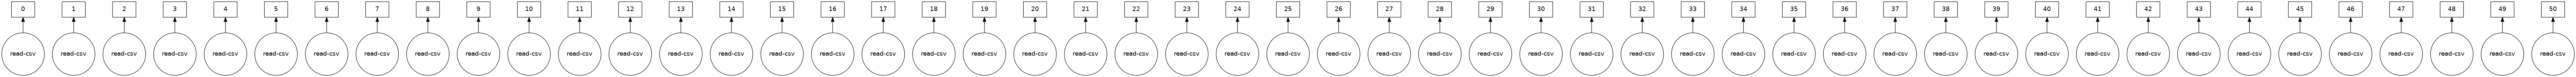

In [7]:
df.visualize()

The Dask dataframe is divided up into 51 Pandas DataFrame object (1 per CSV file). These will be read in through 51 parallel calls to dataframe.read_csv(). We'll leave it like that for now.

## Write a description of the data

Let's say we want to study the soil surface temperature (mean of TDT1_TSOIL and TDT2_TSOIL) over time at all sites.

Instantiating a Dask dataframe does not load the data, but constructs arrays ready to receive the data. We can see the column names and the data types.<br>
First, let's store the "DATE_TIME" column as a datetime64 object, rather than a general object.<br>
Remember, the DASK API build on the Pandas API, where you may have come across the to_datetime() function.

In [8]:
df['DATE_TIME'] = dd.to_datetime(df['DATE_TIME'])
df

,DATE_TIME,SITE_ID,LWIN,LWOUT,SWIN,SWOUT,RN,PRECIP,PA,TA,WS,WD,Q,RH,SNOWD_DISTANCE_COR,UX,UY,UZ,G1,G2,TDT1_TSOIL,TDT1_VWC,TDT2_TSOIL,TDT2_VWC,TDT3_TSOIL,TDT3_VWC,TDT4_TSOIL,TDT4_VWC,TDT5_TSOIL,TDT5_VWC,TDT6_TSOIL,TDT6_VWC,TDT7_TSOIL,TDT7_VWC,TDT8_TSOIL,TDT8_VWC,TDT9_TSOIL,TDT9_VWC,TDT10_TSOIL,TDT10_VWC,STP_TSOIL2,STP_TSOIL5,STP_TSOIL10,STP_TSOIL20,STP_TSOIL50
npartitions=51,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Looking along the row of data types, there are a number of columns with `int64` data. Any attempts to view the data will result in compute errors due to this inconsistent data typing.
For example, `df.head()`:

In [9]:
try:
    df.head() # intentionally fails
except ValueError as ve:
    print(ve)

Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+--------------------+---------+----------+
| Column             | Found   | Expected |
+--------------------+---------+----------+
| SNOWD_DISTANCE_COR | float64 | int64    |
| TDT2_TSOIL         | float64 | int64    |
| TDT2_VWC           | float64 | int64    |
+--------------------+---------+----------+

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'SNOWD_DISTANCE_COR': 'float64',
       'TDT2_TSOIL': 'float64',
       'TDT2_VWC': 'float64'}

to the call to `read_csv`/`read_table`.

Alternatively, provide `assume_missing=True` to interpret
all unspecified integer columns as floats.


2022-09-29 15:00:17,190 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-ca65c91486ddbe7749871d61e0584591', 0)
Function:  execute_task
args:      ((subgraph_callable-d8d20013-9dd8-4256-8c8d-9d78f347fca9, [(<function read_block_from_file at 0x7efcd6069550>, <OpenFile '/home/dmckay/DAwHPC/../DAwHPC_data/COSMOS-UK_ALIC1_HydroSoil_SH_2013-2019.csv'>, 0, 24157118, b'\n'), None, True, True]))
kwargs:    {}
Exception: 'ValueError("Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.\\n\\n+--------------------+---------+----------+\\n| Column             | Found   | Expected |\\n+--------------------+---------+----------+\\n| SNOWD_DISTANCE_COR | float64 | int64    |\\n| TDT2_TSOIL         | float64 | int64    |\\n| TDT2_VWC           | float64 | int64    |\\n+--------------------+---------+----------+\\n\\nUsually this is due to dask\'s dtype inference failing, and\\n*may* be fixed by specifying dtypes manually by adding:\\n\\ndtype={\'SNOWD_DISTANCE_COR\': \'float64\'

This fails because the data types in some of the columns are inconsistent. Three columns, 'SNOWD_DISTANCE_COR', 'TDT2_TSOIL' and 'TDT2_VWC' are mentioned, but there may be more.<br>
Dask reports "expected" data types for these are `int64`, but `float64` values are found.

Let's take a look at the metadata!

In [10]:
metadata = pd.read_csv('../DAwHPC_data/COSMOS-UK_HydroSoil_SH_2013-2019_Metadata.csv')
metadata

,VARIABLE_ID,VARIABLE_NAME,RESOLUTION,UNIT,AGGREGATION,DATA_TYPE,MISSING_VALUE
0,G1,Soil heat flux 1,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
1,G2,Soil heat flux 2,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
2,LWIN,Incoming longwave radiation,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
3,LWOUT,Outgoing longwave radiation,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
4,PA,Atmospheric pressure,30 Minute,hPa,Mean over preceding 30 mins,Floating Point,-9999
5,PRECIP,Precipitation,30 Minute,mm,Total over preceding 30 mins,Floating Point,-9999
6,Q,Absolute humidity,30 Minute,gm-3,Mean over preceding 30 mins,Floating Point,-9999
7,RH,Relative humidity,30 Minute,%,Mean over preceding 30 mins,Floating Point,-9999
8,RN,Net radiation,30 Minute,Wm-2,Mean over preceding 30 mins,Floating Point,-9999
9,SNOWD_DISTANCE_COR,Snow depth,30 Minute,mm,Instantaneous,Floating Point,-9999


So, the DATE_TIME column is a formatted date string, the "SITE_ID" column is a string, and all of the measured data are floats.<br>
We are also told (separately) there will be data missing for some sites as not all sites have all intrument types, and not all sites came online on the same starting date.<br>
Missing data have the value `-9999`.<br>
This is clearly inconsistent - data that are present are floats and missing data are integers!

In [11]:
!head ../DAwHPC_data/COSMOS-UK_ALIC1_HydroSoil_SH_2013-2019.csv

DATE_TIME,SITE_ID,LWIN,LWOUT,SWIN,SWOUT,RN,PRECIP,PA,TA,WS,WD,Q,RH,SNOWD_DISTANCE_COR,UX,UY,UZ,G1,G2,TDT1_TSOIL,TDT1_VWC,TDT2_TSOIL,TDT2_VWC,TDT3_TSOIL,TDT3_VWC,TDT4_TSOIL,TDT4_VWC,TDT5_TSOIL,TDT5_VWC,TDT6_TSOIL,TDT6_VWC,TDT7_TSOIL,TDT7_VWC,TDT8_TSOIL,TDT8_VWC,TDT9_TSOIL,TDT9_VWC,TDT10_TSOIL,TDT10_VWC,STP_TSOIL2,STP_TSOIL5,STP_TSOIL10,STP_TSOIL20,STP_TSOIL50
2015-03-06T13:30:00Z,ALIC1,278.4,371.9,521.5,62.95,365.05,-9999,-9999,10.19,3.62,210.7,5.793,60.93,-9999,-9999,-9999,-9999,40.617,45.8,5.89,19.44,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,7.903,6.673,5.761,5.127,5.474
2015-03-06T14:00:00Z,ALIC1,275.9,373.0,526.0,63.06,365.84,0.0,1020.0,10.43,4.329,211.5,5.858,60.69,-9999,-9999,-9999,-9999,33.512,43.042,6.06,19.51,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,7.987,6.823,5.893,5.165,5.491
2015-03-06T14:30:00Z,ALIC1,275.5,373.0,489.8,58.98,333.32,0.0,1019.0,

The first file alphabetically has `-9999` values in the columns reported in the Dask error - we need to fix these!<br>
Dask has used the first row of data from the first CSV file to define data types for each column - the error arises when it finds a row of data that does not conform to expected data types.

Let's load the data again, but this time deal with missing data, coerce data types, and ignore columns of data we don't need.

In [12]:
# a list of the columns we are interested in - we'll look at the air temperature and the soil temperature closest to the surface
cols = ['DATE_TIME','SITE_ID','TA','TDT1_TSOIL','TDT2_TSOIL']
# a dictionary of data types for each column
dtypes = {'DATE_TIME':object,'SITE_ID':str,'TA':np.float64,'TDT1_TSOIL':np.float64,'TDT2_TSOIL':np.float64}
# Note: we read "DATE_TIME" as a general object, but pass this column to the "parse_dates" option.
# We use dataframe.replace() to change -9999 to np.nan (np.nan is a null type that is stored as float64)
df2 = dd.read_csv('../DAwHPC_data/*2019.csv', usecols=cols, dtype=dtypes, parse_dates=['DATE_TIME']).replace(-9999,np.nan)
df2

,DATE_TIME,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
npartitions=51,,,,,
,"datetime64[ns, UTC]",object,float64,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


Now we can view the first few rows of the first file. Check the Dask Dashboard for activity.

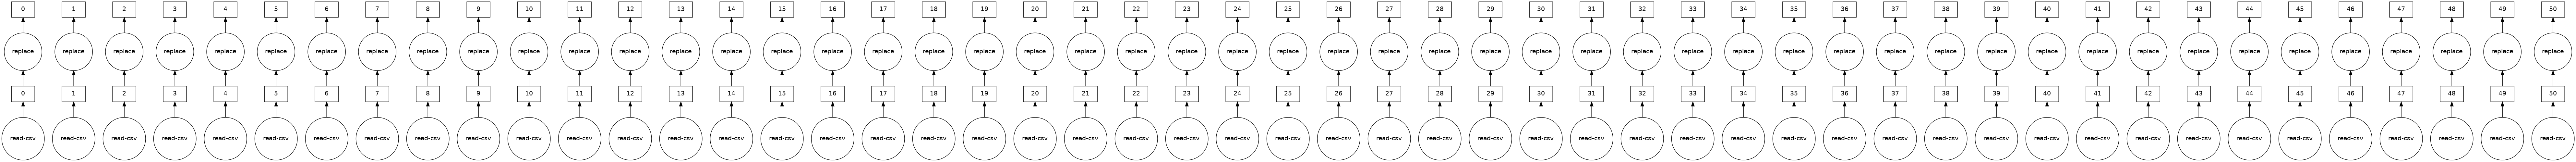

In [13]:
df2.visualize()

Now, after the 51 parallel calls to read_csv(), we have an additional 51 parallel calls to replace().

In [14]:
%time df2.head() # head() implicitly runs compute()

CPU times: user 110 ms, sys: 2.16 ms, total: 112 ms
Wall time: 650 ms


,DATE_TIME,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
0,2015-03-06 13:30:00+00:00,ALIC1,10.19,5.89,NaN
1,2015-03-06 14:00:00+00:00,ALIC1,10.43,6.06,NaN
2,2015-03-06 14:30:00+00:00,ALIC1,10.61,6.23,NaN
3,2015-03-06 15:00:00+00:00,ALIC1,10.69,6.37,NaN
4,2015-03-06 15:30:00+00:00,ALIC1,10.39,6.46,NaN


We will now perform a simple task of viewing the temperature trend at each site over the lifetime of the data. For this to be more efficient, the "DATE_TIME" column should be the index of the dataframe.

In [15]:
df2.set_index('DATE_TIME')

,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
npartitions=51,,,,
2013-10-02 13:30:00+00:00,object,float64,float64,float64
2014-06-25 14:00:00+00:00,...,...,...,...
...,...,...,...,...
2019-12-06 10:00:00+00:00,...,...,...,...
2020-01-01 00:00:00+00:00,...,...,...,...


In [16]:
df2.head()

,DATE_TIME,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
0,2015-03-06 13:30:00+00:00,ALIC1,10.19,5.89,NaN
1,2015-03-06 14:00:00+00:00,ALIC1,10.43,6.06,NaN
2,2015-03-06 14:30:00+00:00,ALIC1,10.61,6.23,NaN
3,2015-03-06 15:00:00+00:00,ALIC1,10.69,6.37,NaN
4,2015-03-06 15:30:00+00:00,ALIC1,10.39,6.46,NaN


In [22]:
%time df2.groupby('SITE_ID').get_group('ALIC1').compute()

CPU times: user 1.14 s, sys: 176 ms, total: 1.32 s
Wall time: 4.9 s


,DATE_TIME,SITE_ID,TA,TDT1_TSOIL,TDT2_TSOIL
0,2015-03-06 13:30:00+00:00,ALIC1,10.190,5.89,NaN
1,2015-03-06 14:00:00+00:00,ALIC1,10.430,6.06,NaN
2,2015-03-06 14:30:00+00:00,ALIC1,10.610,6.23,NaN
3,2015-03-06 15:00:00+00:00,ALIC1,10.690,6.37,NaN
4,2015-03-06 15:30:00+00:00,ALIC1,10.390,6.46,NaN
...,...,...,...,...,...
84545,2019-12-31 22:00:00+00:00,ALIC1,6.203,6.89,6.73
84546,2019-12-31 22:30:00+00:00,ALIC1,6.051,6.87,6.72
84547,2019-12-31 23:00:00+00:00,ALIC1,5.881,6.84,6.70
84548,2019-12-31 23:30:00+00:00,ALIC1,5.738,6.82,6.70


In [23]:
df3 = df2.persist()
%time df3.groupby('SITE_ID')['TA'].mean().compute()
#Run this cell twice and observe the difference

CPU times: user 1.42 s, sys: 161 ms, total: 1.58 s
Wall time: 5.28 s


SITE_ID
ALIC1    10.927174
BALRD     8.880826
BICKL    10.048129
BUNNY    10.628194
CARDT    11.181747
CGARW     9.691159
CHIMN    10.443856
CHOBH    10.635571
COCHN     8.303823
COCLP     8.848499
CRICH     9.182283
EASTB     8.381680
ELMST    10.647160
EUSTN    10.907918
FINCH    11.172987
FIVET     9.393436
GISBN     8.329593
GLENS     6.623934
GLENW     8.332434
HADLW    10.720809
HARTW     8.358973
HARWD     7.902479
HENFS     9.631647
HILLB     9.554486
HLACY    11.543561
HOLLN     9.924608
HYBRY    10.058990
LIZRD    11.140881
LODTN    10.261159
LULLN    10.959323
MOORH     6.985737
MOREM    10.020592
MORLY    10.680815
NWYKE    10.282385
PLYNL     7.285601
PORTN    10.498931
RDMER    11.028771
REDHL    10.923675
RISEH    10.676650
ROTHD    10.583686
SHEEP     9.911862
SOURH     8.041314
SPENF     9.969199
STGHT    10.242394
STIPS     7.924171
SYDLG     9.746100
TADHM    10.774289
WADDN    10.557415
WIMPL     8.828801
WRTTL    11.255351
WYTH1    10.458253
Name: TA, dtype: float6

CPU times: user 5.31 s, sys: 94.5 ms, total: 5.41 s
Wall time: 5.9 s


<AxesSubplot:xlabel='DATE_TIME'>

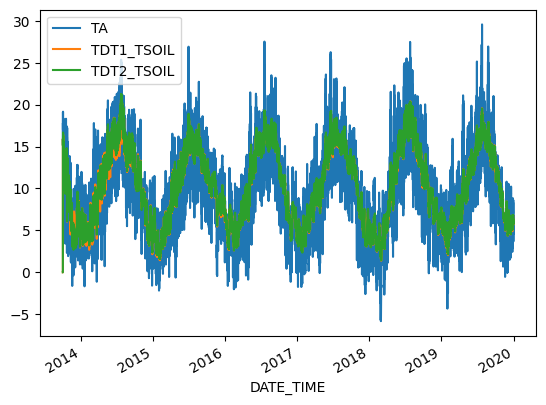

In [24]:
%time df3.groupby('DATE_TIME').mean().compute().plot() # this is quite slow and the resulting plot is not all that useful!

Wow, that's a lot of data! Maybe a bit too much. This shows the seasonal temperature changes in the UK.<br>
Let's combine the soil temperature columns by averaging them, and change our cadence (sampling) to 1 day.

In [25]:
df3['SOIL_TEMP'] = df3[['TDT1_TSOIL','TDT2_TSOIL']].mean(axis=1)
df3 = df3.drop(columns=['TDT1_TSOIL','TDT2_TSOIL'])
df3

,DATE_TIME,SITE_ID,TA,SOIL_TEMP
npartitions=51,,,,
,"datetime64[ns, UTC]",object,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


CPU times: user 3.25 s, sys: 125 ms, total: 3.37 s
Wall time: 3.8 s


<AxesSubplot:xlabel='DATE_TIME'>

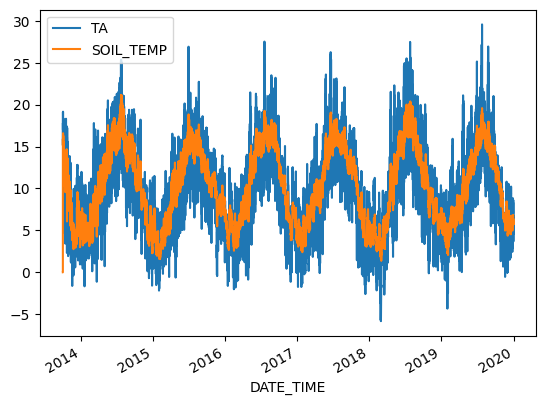

In [26]:
%time df3.groupby('DATE_TIME').mean().compute().plot() 

In [27]:
# Currently we are dividing our data up by the number of inisital CSV files:
df3.npartitions

51

In [28]:
df3.memory_usage_per_partition().compute()

0     2705728
1     3158816
2     2762336
3     2764928
4     2536992
5     1967072
6     3504448
7     2721056
8     1320064
9     2866944
10    2850016
11    3020768
12    1900736
13    2104992
14    1440192
15     850112
16    3017632
17    3160512
18    1988320
19    1783424
20    3151168
21    2587552
22    2266464
23    1989728
24     967200
25    3237248
26    1332608
27    2920864
28    2065120
29    2828480
30    2847168
31     630720
32    3160928
33    2922592
34    2891648
35    2825728
36    2022944
37    2169504
38    2052768
39    3050144
40    3470592
41    2870432
42    1741344
43    2451200
44    2889952
45     612256
46    2925472
47    3453568
48     171584
49    1398784
50    1596608
dtype: int64

In [40]:
df3['SITE_ID'].unique().compute()

0     ALIC1
1     BALRD
2     BICKL
3     BUNNY
4     CARDT
5     CGARW
6     CHIMN
7     CHOBH
8     COCHN
9     COCLP
10    CRICH
11    EASTB
12    ELMST
13    EUSTN
14    FINCH
15    FIVET
16    GISBN
17    GLENS
18    GLENW
19    HADLW
20    HARTW
21    HARWD
22    HENFS
23    HILLB
24    HLACY
25    HOLLN
26    HYBRY
27    LIZRD
28    LODTN
29    LULLN
30    MOORH
31    MOREM
32    MORLY
33    NWYKE
34    PLYNL
35    PORTN
36    RDMER
37    REDHL
38    RISEH
39    ROTHD
40    SHEEP
41    SOURH
42    SPENF
43    STGHT
44    STIPS
45    SYDLG
46    TADHM
47    WADDN
48    WIMPL
49    WRTTL
50    WYTH1
Name: SITE_ID, dtype: object

In [49]:
df4 = df3.groupby('SITE_ID').mean().compute()
df4

,TA,SOIL_TEMP
SITE_ID,,
ALIC1,10.927174,10.571776
BALRD,8.880826,9.643821
BICKL,10.048129,10.184700
BUNNY,10.628194,11.329520
CARDT,11.181747,11.600140
CGARW,9.691159,10.823589
CHIMN,10.443856,11.250348
CHOBH,10.635571,11.176681
COCHN,8.303823,8.910274


In [58]:
# We can, instead, divide up the data by the frequency of measurements, which is hourly.
divisions = tuple(pd.date_range(start='2015', end='2020', freq='12h'))
df4 = df3.set_index('DATE_TIME', divisions=divisions)

In [59]:
df4.npartitions

3652

This is _not_ a good idea. In Dask we want a large enough number of partitions that each fits comfortably in memory, but we don't want too many partitions as many operations will scale relative to this number.

In [60]:
df4 = df4.repartition(npartitions=df4.npartitions // 100)

In [61]:
df4.npartitions

36

In [62]:
#df4 = df4.persist()

In [63]:
df4.visualize()

2022-09-29 15:22:00,315 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-29 15:22:00,315 - distributed.nanny - ERROR - Worker process died unexpectedly
Exception in thread Nanny stop queue watch:
Traceback (most recent call last):
  File "/home/dmckay/miniconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
2022-09-29 15:22:00,315 - distributed.nanny - ERROR - Worker process died unexpectedly
    self.run()
  File "/home/dmckay/miniconda3/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/distributed/nanny.py", line 884, in watch_stop_q
    child_stop_q.close()
  File "/home/dmckay/miniconda3/lib/python3.9/multiprocessing/queues.py", line 143, in close
    self._reader.close()
  File "/home/dmckay/miniconda3/lib/python3.9/multiprocessing/connection.py", line 182, in close
2022-09-29 15:22:00,317 - distributed.nanny - ERROR - Worker process died unexpec

In [73]:
%time df4.iloc[:10,1].groupby('SITE_ID')['TA'].mean().compute().plot() 

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [37]:
len(df3)

2022-09-29 14:55:19,326 - distributed.core - ERROR - Exception while handling op get_data
Traceback (most recent call last):
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/distributed/nanny.py", line 942, in _run
    loop.run_sync(run)
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/dmckay/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/home/dmckay/miniconda3/lib/python3.9/asyncio/base_events.py", line 1869, in _run_once
    event_list = self._selector.select(timeout)
  File "/home/dmckay/miniconda3/lib/python3.9/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

T

KeyboardInterrupt: 

2022-09-29 14:55:22,788 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-09-29 14:55:27,042 - distributed.nanny - WARNING - Restarting worker
2022-09-29 14:55:30,873 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/distributed/nanny.py", line 942, in _run
    loop.run_sync(run)
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/home/dmckay/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/dmckay/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/home/dmckay/miniconda3/lib/python3.9/asyncio/base_events.py", line 1869, in _run_once
    event_list = self._selector.

In [67]:
# Now we will resample the data to daily, where the daily values are the mean of the hourly values within that day.
df4 = df4.resample('1d').mean()

In [68]:
df4.head()

,TA,SOIL_TEMP
DATE_TIME,,
2015-01-01 00:00:00+00:00,9.334670,5.134964
2015-01-02 00:00:00+00:00,5.561931,5.635543
2015-01-03 00:00:00+00:00,3.863055,4.698284
2015-01-04 00:00:00+00:00,2.091980,3.765000
2015-01-05 00:00:00+00:00,6.463837,4.575027


In [69]:
%time df4.compute()

CPU times: user 108 ms, sys: 30 ms, total: 138 ms
Wall time: 178 ms


,TA,SOIL_TEMP
DATE_TIME,,
2015-01-01 00:00:00+00:00,9.334670,5.134964
2015-01-02 00:00:00+00:00,5.561931,5.635543
2015-01-03 00:00:00+00:00,3.863055,4.698284
2015-01-04 00:00:00+00:00,2.091980,3.765000
2015-01-05 00:00:00+00:00,6.463837,4.575027
...,...,...
2019-12-28 00:00:00+00:00,7.983904,6.534356
2019-12-29 00:00:00+00:00,7.252096,6.697119
2019-12-30 00:00:00+00:00,5.988444,6.264111


CPU times: user 303 ms, sys: 40.3 ms, total: 343 ms
Wall time: 380 ms


<AxesSubplot:xlabel='DATE_TIME'>

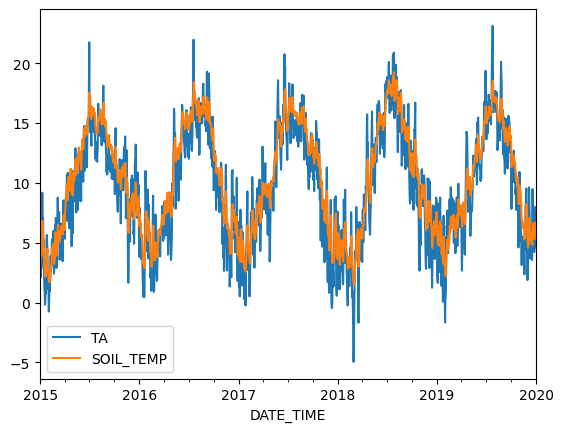

In [71]:
%time df4.groupby('DATE_TIME').mean().compute().plot() 

What does the above plot show? (Hint: what column has been dropped from df4?)